In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import resample
from math import sqrt
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

To forecast the sales of the two best-selling products, I will split the dataset into two, one for item A and one for item B.

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset.csv')

# Keep only one observation per day
data = data.drop_duplicates(subset=['date', 'item_name'], keep='first')

# Filter the data for item_name 'A'
data_a = data[data['item_name'] == 'A']

# Filter the data for item_name 'B'
data_b = data[data['item_name'] == 'B']

# Save the filtered data to new CSV files
data_a.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv', index=False)
data_b.to_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv', index=False)

Features processing A and B

In [ ]:
# Model LightGBM A

data_a = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_A.csv', index_col='date')

# Convert the index to datetime format
data_a.index = pd.to_datetime(data_a.index)

# Check the number of unique values in 'item_nbr', 'item_name', and 'class'
print("Unique values in 'item_nbr':", data_a['item_nbr'].nunique())
print("Unique values in 'item_name':", data_a['item_name'].nunique())
print("Unique values in 'class':", data_a['class'].nunique())

# If these columns have only one unique value, drop them from the dataset
if data_a['item_nbr'].nunique() == 1:
    data_a.drop('item_nbr', axis=1, inplace=True)
if data_a['item_name'].nunique() == 1:
    data_a.drop('item_name', axis=1, inplace=True)
if data_a['class'].nunique() == 1:
    data_a.drop('class', axis=1, inplace=True)

# Also, drop the 'id' column as it is just an identifier
data_a.drop('id', axis=1, inplace=True)

#data_a.drop(['month', 'day_of_month', 'week_of_month', 'day_of_week', 'season'], axis=1, inplace=True)
#data_a.drop(['month_sin', 'day_of_month_sin', 'week_of_month_sin', 'day_of_week_sin', 'season_sin', 'month_cos', 'day_of_month_cos', 'week_of_month_cos', 'day_of_week_cos', 'season_cos'], axis=1, inplace=True)
print(data_a.head())

Unique values in 'item_nbr': 1
Unique values in 'item_name': 1
Unique values in 'class': 1
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-01-02         117        False           False              True   
2015-01-03         110        False           False             False   
2015-01-04         180        False           False             False   
2015-01-05         106        False           False             False   
2015-01-06          87        False           False             False   

            holiday_local  month  day_of_month  week_of_month  day_of_week  \
date                                                                         
2015-01-02          False      1             2              1            5   
2015-01-03          False      1             3              1            6   
2015-01-04          False      1             4              1            7   
2015-01

In [ ]:
# Model LightGBM B

data_b = pd.read_csv('/content/drive/MyDrive/Master Thesis/Final Data/final_dataset_B.csv', index_col='date')

# Convert the index to datetime format
data_b.index = pd.to_datetime(data_b.index)

# Check the number of unique values in 'item_nbr', 'item_name', and 'class'
print("Unique values in 'item_nbr':", data_b['item_nbr'].nunique())
print("Unique values in 'item_name':", data_b['item_name'].nunique())
print("Unique values in 'class':", data_b['class'].nunique())

# If these columns have only one unique value, drop them from the dataset
if data_b['item_nbr'].nunique() == 1:
    data_b.drop('item_nbr', axis=1, inplace=True)
if data_b['item_name'].nunique() == 1:
    data_b.drop('item_name', axis=1, inplace=True)
if data_b['class'].nunique() == 1:
    data_b.drop('class', axis=1, inplace=True)

# Also, drop the 'id' column as it is just an identifier
data_b.drop('id', axis=1, inplace=True)

#data_b.drop(['month', 'day_of_month', 'week_of_month', 'day_of_week', 'season'], axis=1, inplace=True)
#data_b.drop(['month_sin', 'day_of_month_sin', 'week_of_month_sin', 'day_of_week_sin', 'season_sin', 'month_cos', 'day_of_month_cos', 'week_of_month_cos', 'day_of_week_cos', 'season_cos'], axis=1, inplace=True)
print(data_b.head())

Unique values in 'item_nbr': 1
Unique values in 'item_name': 1
Unique values in 'class': 1
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-01-02          90        False           False              True   
2015-01-03          97        False           False             False   
2015-01-04          94        False           False             False   
2015-01-05          81        False           False             False   
2015-01-06         119        False           False             False   

            holiday_local  month  day_of_month  week_of_month  day_of_week  \
date                                                                         
2015-01-02          False      1             2              1            5   
2015-01-03          False      1             3              1            6   
2015-01-04          False      1             4              1            7   
2015-01

Dataset A and B: Training set of 6 month history before the start of the evaluation period (evaluation period = May 2016)

In [ ]:
# Two years of data
dataset_lgbm_A = data_a['2015-01-01':'2017-01-01']
dataset_lgbm_B = data_b['2015-01-01':'2017-01-01']

# Calculate the start date six months before the test start date
historical_start_date = pd.to_datetime('2016-04-30') - pd.DateOffset(months=6)

# Calculate the end date as the test start date
historical_end_date = pd.to_datetime('2016-04-30')

# Filter the historical data for six months period prior to the test start date
train_A = data_a[(data_a.index >= historical_start_date) & (data_a.index < historical_end_date)]
train_B = data_b[(data_b.index >= historical_start_date) & (data_b.index < historical_end_date)]

# Display the first row of the train data
print("\nFirst row of train data:")
print(train_A)
print("Shape:", train_A.shape)

print("\nFirst row of train data:")
print(train_B)
print("Shape:", train_B.shape)


First row of train data:
            unit_sales  onpromotion  event_national  holiday_national  \
date                                                                    
2015-10-30          39        False           False             False   
2015-10-31          76        False           False             False   
2015-11-01          55        False           False             False   
2015-11-02          70        False           False              True   
2015-11-03         106        False           False              True   
...                ...          ...             ...               ...   
2016-04-25          55        False            True             False   
2016-04-26          40        False            True             False   
2016-04-27          52        False            True             False   
2016-04-28          35        False            True             False   
2016-04-29          66        False            True             False   

            holiday_loca

# LightGBM Models

## Model Features and target variable definition

Definition of the features and target variable (unit_sales) for the LightGBM model.

In [ ]:
# Model LightGBM A

# Define features and target variable
features_lgbm_A = train_A.columns.tolist()
features_lgbm_A.remove('unit_sales')  # Remove target variable from features
target_lgbm_A = 'unit_sales'

# Prepare the data for training
X_train_lgbm_A = train_A[features_lgbm_A]
y_train_lgbm_A = train_A[target_lgbm_A]

print("\nFirst row of x train data:")
print(X_train_lgbm_A.head())
print("Shape:", X_train_lgbm_A.shape)

print("\nFirst row of y train data:")
print(y_train_lgbm_A.head())
print("Shape:", y_train_lgbm_A.shape)


First row of x train data:
            onpromotion  event_national  holiday_national  holiday_local  \
date                                                                       
2015-10-30        False           False             False          False   
2015-10-31        False           False             False          False   
2015-11-01        False           False             False          False   
2015-11-02        False           False              True          False   
2015-11-03        False           False              True          False   

            month  day_of_month  week_of_month  day_of_week  year  season  \
date                                                                        
2015-10-30     10            30              5            5  2015       3   
2015-10-31     10            31              5            6  2015       3   
2015-11-01     11             1              1            7  2015       3   
2015-11-02     11             2              1        

In [ ]:
# Model LightGBM B

# Define features and target variable
features_lgbm_B = train_A.columns.tolist()
features_lgbm_B.remove('unit_sales')  # Remove target variable from features
target_lgbm_B = 'unit_sales'

# Prepare the data for training
X_train_lgbm_B = train_B[features_lgbm_B]
y_train_lgbm_B = train_B[target_lgbm_B]

print("\nFirst row of x train data:")
print(X_train_lgbm_B.head())
print("Shape:", X_train_lgbm_B.shape)

print("\nFirst row of y train data:")
print(y_train_lgbm_B.head())
print("Shape:", y_train_lgbm_B.shape)


First row of x train data:
            onpromotion  event_national  holiday_national  holiday_local  \
date                                                                       
2015-10-30        False           False             False          False   
2015-10-31        False           False             False          False   
2015-11-01        False           False             False          False   
2015-11-02        False           False              True          False   
2015-11-03        False           False              True          False   

            month  day_of_month  week_of_month  day_of_week  year  season  \
date                                                                        
2015-10-30     10            30              5            5  2015       3   
2015-10-31     10            31              5            6  2015       3   
2015-11-01     11             1              1            7  2015       3   
2015-11-02     11             2              1        

## Best LightGBM models: Hyperparameter tuning

Find the right parameters:

*   Objective: Forecasting time series is a regression application. By default, lgbm uses regression parameter with L2 loss function. I use the metric RMSE because it penalize large errors which is what we want to avoid to reduce food waste.

*   Boosting: By default uses traditional Gradient boosting decision tree


https://lightgbm.readthedocs.io/en/latest/Parameters.html



Hyperparameter tuning:

To find the best LightGBM model, we will try different combinations of hyperparameters. The gridsearch function will evaluate each combination and select the one with the minimum RMSE. GridSearchCV also performs cross-validation to robustly evaluate the models on the training data.

*   num_leaves: This is the main parameter to control complexity. Unconstrained depth can induce over-fitting when trying to tune the num_leaves. I should be be smaller than 2^(max_depth)

*   max_depth: maximum depth of the individual trees in the ensemble

*   learning_rate: controls the step size or rate at which the boosting algorithm learns from the data. Small for better accuracy

*   bagging_fraction: control how often a new sample is drawn. For example, "bagging_freq": 5, "bagging_fraction": 0.75 tells LightGBM “re-sample without replacement every 5 iterations, and draw samples of 75% of the training data”. **Avoid overfitting**


https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

https://www.mygreatlearning.com/blog/gridsearchcv/

In [ ]:
# Model LightGBM A

# Define the parameter grid for grid search
param_grid_lgbm_A = {
    'num_leaves': [4, 20, 40],                # Control the complexity of the tree model
    'max_depth': [2, 5, 8],                   # Maximum depth of each tree; deeper trees can model more complex patterns
    'learning_rate': [0.01, 0.05, 0.1],       # Learning rate to control how quickly the model adapts; lower values make learning more robust but slower
    'bagging_fraction': [0.6, 0.8, 1.0],      # Fraction of the data to be used for each iteration, used to prevent overfitting
    'bagging_freq': [1, 5, 10],               # Frequency of performing bagging; higher values mean less frequent updates
    'objective': ['regression'],
    'metric': ['rmse'],
}


# Instantiate the LightGBM model
lgb_model_A = lgb.LGBMRegressor()

# Instantiate the GridSearchCV object
grid_search_A = GridSearchCV(estimator=lgb_model_A, param_grid=param_grid_lgbm_A, cv=10, scoring='neg_root_mean_squared_error')

# Perform the grid search
grid_search_A.fit(X_train_lgbm_A, y_train_lgbm_A)

# Get the best parameters and best score
best_params_lgbm_A = grid_search_A.best_params_
best_score_lgbm_A = -grid_search_A.best_score_

print("Best Parameters:", best_params_lgbm_A)
print("Best RMSE:", best_score_lgbm_A)

# Instantiate the best LightGBM model with the final parameters
best_lgb_model_A = lgb.LGBMRegressor(**best_params_lgbm_A)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [ ]:
# Model LightGBM B

# Define the parameter grid for grid search
param_grid_lgbm_B = {
    'num_leaves': [4, 20, 40],                # Control the complexity of the tree model
    'max_depth': [2, 5, 8],                   # Maximum depth of each tree; deeper trees can model more complex patterns
    'learning_rate': [0.01, 0.05, 0.1],       # Learning rate to control how quickly the model adapts; lower values make learning more robust but slower
    'bagging_fraction': [0.6, 0.8, 1.0],      # Fraction of the data to be used for each iteration, used to prevent overfitting
    'bagging_freq': [1, 5, 10],               # Frequency of performing bagging; higher values mean less frequent updates
    'objective': ['regression'],
    'metric': ['rmse'],
}

# Instantiate the LightGBM model
lgb_model_B = lgb.LGBMRegressor()

# Instantiate the GridSearchCV object
grid_search_B = GridSearchCV(estimator=lgb_model_B, param_grid=param_grid_lgbm_B, cv=10, scoring='neg_root_mean_squared_error')

# Perform the grid search
grid_search_B.fit(X_train_lgbm_B, y_train_lgbm_B)

# Get the best parameters and best score
best_params_lgbm_B = grid_search_B.best_params_
best_score_lgbm_B = -grid_search_B.best_score_

print("Best Parameters:", best_params_lgbm_B)
print("Best RMSE:", best_score_lgbm_B)

# Instantiate the best LightGBM model with the final parameters
best_lgb_model_B = lgb.LGBMRegressor(**best_params_lgbm_B)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

## Model evaluation

**Model Training and Forecasting Strategy:**

Real-World Simulation: The model emulates real-world scenarios by generating daily forecasts for the next day, utilizing a rolling window approach with the last six months of data to continuously train the model.

Dynamic Training Data: The dataset for training is refreshed daily, incorporating the most recent six months' data. This ensures that each forecast is based on the latest trends and information. Each training set produces a forecast for the immediate following day.

Bootstrap Aggregation: To improve the model's precision, each training dataset is bootstrapped 20 times. Multiple samples are drawn (with replacement) from the six-month data pool, and the model is trained on these samples. The daily forecast is then derived as the average of these bootstrapped predictions.

This means that every daily forecast within the forecasted period is generated by training the model on 20 bootstrapped datasets. For instance, the forecast for May 4th is obtained by averaging predictions from 20 different training sets that span the six months leading up to May 4th. Similarly, for May 5th, 20 different training sets based on the preceding six months are used to compute the forecast by averaging the results.

**Evaluation Period and Methodology:**

Testing Timeline: The model's effectiveness is evaluated over a 31-day span, from May 1, 2016, to May 31, 2016.

Comparison of Predicted and Actual Sales: Daily forecasted sales are matched against actual sales figures for each corresponding day. The forecasts represent the mean outcome from the bootstrapped models.

Performance Metric: The accuracy of the model is measured using:

*   RMSE
*   RMSE%
*   variance RMSE
*   MAE
*   MAPE
*   MAE%
*   Bias
*   Bias%


This methodology ensures that the model is resilient, adjusts to current market conditions, and reflects a realistic operational forecasting process.

## Evaluation Functions

Prepare training data for the model. This function extracts six months of data leading up to the day before `start_date`.

In [ ]:
def prepare_training_data(data, start_date, end_date):

    # Calculate the start of the training period (6 months before the start_date)
    train_start = pd.to_datetime(start_date) - timedelta(days=180)
    train_end = pd.to_datetime(start_date) - timedelta(days=1)

    # Extract the training data from the dataset
    training_data = data[train_start:train_end]

    return training_data

Forecast daily sales using a rolling window approach and bootstrapping.

In [ ]:
# Model LightGBM A

def forecast_sales_A(data, test_start_date, test_end_date):

    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Bootstrap and train model
        daily_forecasts = []
        for _ in range(20):  # Bootstrap 20 times
            bootstrapped_data = resample(train_data, replace=True, n_samples=len(train_data))

            # Train LightGBM model
            train_features = bootstrapped_data.drop('unit_sales', axis=1)
            train_target = bootstrapped_data['unit_sales']
            lgbm_model = best_lgb_model_A
            lgbm_model.fit(train_features, train_target)

            # Predict for the current day
            current_features = data.loc[current_date:current_date].drop('unit_sales', axis=1)
            prediction = lgbm_model.predict(current_features)
            daily_forecasts.append(prediction[0])

        # Average the predictions from the bootstrapped models
        predictions[current_date.strftime('%Y-%m-%d')] = np.mean(daily_forecasts)
        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

In [ ]:
# Model LightGBM B

def forecast_sales_B(data, test_start_date, test_end_date):

    current_date = pd.to_datetime(test_start_date)
    end_date = pd.to_datetime(test_end_date)
    predictions = {}
    training_dates = []

    while current_date <= end_date:
        # Prepare training data for the current day
        train_data = prepare_training_data(data, str(current_date), str(current_date))
        train_start = current_date - timedelta(days=180)
        train_end = current_date - timedelta(days=1)

        # Bootstrap and train model
        daily_forecasts = []
        for _ in range(20):  # Bootstrap 20 times
            bootstrapped_data = resample(train_data, replace=True, n_samples=len(train_data))

            # Train LightGBM model
            train_features = bootstrapped_data.drop('unit_sales', axis=1)
            train_target = bootstrapped_data['unit_sales']
            lgbm_model = best_lgb_model_B
            lgbm_model.fit(train_features, train_target)

            # Predict for the current day
            current_features = data.loc[current_date:current_date].drop('unit_sales', axis=1)
            prediction = lgbm_model.predict(current_features)
            daily_forecasts.append(prediction[0])

        # Average the predictions from the bootstrapped models
        predictions[current_date.strftime('%Y-%m-%d')] = np.mean(daily_forecasts)
        # Log training set start and end dates
        training_dates.append({'date': current_date.strftime('%Y-%m-%d'), 'start': train_start, 'end': train_end})

        # Move to the next day
        current_date += timedelta(days=1)

    return predictions, training_dates

Evaluation of the forecast

In [ ]:
def evaluate_forecast(predictions, actual_data):
    errors = []
    mae_values = []
    mape_values = []

    for date, pred in predictions.items():
        if date in actual_data.index:
            actual_sales = actual_data.at[date, 'unit_sales']
            error = pred - actual_sales
            errors.append(error)
            mae_values.append(abs(error))
            if actual_sales != 0:
                mape_values.append((abs(error) / actual_sales) * 100)

    # Calculate overall metrics
    actuals = [actual_data.at[date, 'unit_sales'] for date in predictions if date in actual_data.index]
    preds = [predictions[date] for date in predictions if date in actual_data.index]
    overall_rmse = sqrt(mean_squared_error(actuals, preds))
    overall_mae = np.mean(mae_values)  # Mean Absolute Error
    overall_mape = np.mean(mape_values) if mape_values else None  # Mean Absolute Percentage Error
    mae_percent = (np.sum(mae_values) / np.sum(actuals)) * 100 if actuals else None  # MAE as a percentage of total actuals
    bias = np.mean(errors) if errors else None  # Calculate bias
    bias_percent = (np.sum(errors) / np.sum(actuals)) * 100 if actuals else None  # Bias as a percentage of total actuals
    overall_rmse_percent = (overall_rmse / np.mean(actuals)) * 100 if actuals else None  # RMSE as a percentage of total actuals

    # Compute the variance of daily RMSEs
    variance_of_rmses = np.var([sqrt(mean_squared_error([actual], [pred])) for actual, pred in zip(actuals, preds)])

    # Format the output as a table
    results = {
        "Metric": ["Overall RMSE", "RMSE %", "Variance of RMSEs", "Overall MAE", "MAE %", "Overall MAPE", "Bias", "Bias %"],
        "Value": [overall_rmse, overall_rmse_percent, variance_of_rmses, overall_mae, mae_percent, overall_mape, bias, bias_percent]
    }

    return pd.DataFrame(results)

Plot the forecasted sales against the actual sales.

In [ ]:
def plot_forecast_vs_actual(predictions, actual_data, model_name):

    # Convert predictions dictionary to DataFrame for easier plotting
    pred_df = pd.DataFrame(list(predictions.items()), columns=['date', 'predicted_sales'])
    pred_df['date'] = pd.to_datetime(pred_df['date'])
    pred_df.set_index('date', inplace=True)

    # Plot settings
    plt.figure(figsize=(12, 6))
    plt.plot(pred_df.index, pred_df['predicted_sales'], label='Predicted Sales', marker='o', linestyle='-', color='blue')
    plt.plot(actual_data.index, actual_data['unit_sales'], label='Actual Sales', marker='x', linestyle='--', color='red')

    # Enhance the plot
    plt.title(f'{model_name} - Forecasted Sales vs Actual Sales')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better readability

    # Show the plot
    plt.tight_layout()
    plt.show()

## Result Model LightGBM A

Forecast the value for the evaluation period




In [ ]:
# Model LightGBM A

# Define the testing period
test_start_date_A = '2016-05-01'
test_end_date_A = '2016-05-31'

# Run the forecast
predictions_A, training_dates_A = forecast_sales_A(dataset_lgbm_A, test_start_date_A, test_end_date_A)
print("Forecasting completed.")

# Ensure predictions are being calculated for each expected day
expected_days_A = pd.date_range(start=test_start_date_A, end=test_end_date_A)
missing_days_A = [day.strftime('%Y-%m-%d') for day in expected_days_A if day.strftime('%Y-%m-%d') not in predictions_A]
if missing_days_A:
    print("Warning: No predictions for days:", missing_days_A)
else:
    print("All days have predictions.")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

Evaluate the results

In [ ]:
# Model LightGBM A

# Extract actual sales data for the test period
actual_data_A = dataset_lgbm_A[test_start_date_A:test_end_date_A]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_A.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_A)} days.")

results_A = evaluate_forecast(predictions_A, actual_data_A)
print(results_A)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric      Value
0       Overall RMSE  13.180387
1             RMSE %  21.236591
2  Variance of RMSEs  83.635608
3        Overall MAE   9.491417
4              MAE %  15.292824
5       Overall MAPE  15.896624
6               Bias  -0.327612
7             Bias %  -0.527857


Predicted value for each day

In [ ]:
# Model LightGBM A

print("Sample predictions:")
for date in list(predictions_A.keys())[:]:
    print(f"{date}: {predictions_A[date]}")

Sample predictions:
2016-05-01: 116.31881515916923
2016-05-02: 72.81078964672874
2016-05-03: 58.11972956788776
2016-05-04: 56.506957509409645
2016-05-05: 49.70952888012476
2016-05-06: 50.566549713066316
2016-05-07: 72.20920022616312
2016-05-08: 98.78246166883453
2016-05-09: 56.61629855732933
2016-05-10: 44.20739367271565
2016-05-11: 42.82143489539068
2016-05-12: 43.53288923761426
2016-05-13: 46.63376963397648
2016-05-14: 68.41881007688355
2016-05-15: 96.51143487006165
2016-05-16: 60.84745499920405
2016-05-17: 46.65694596729642
2016-05-18: 47.294714180021785
2016-05-19: 45.318531385959155
2016-05-20: 45.12587472401913
2016-05-21: 70.94540746501583
2016-05-22: 97.39537491024429
2016-05-23: 58.23229865022273
2016-05-24: 53.15180125198644
2016-05-25: 44.701836182960044
2016-05-26: 41.09747568666704
2016-05-27: 49.45536707756072
2016-05-28: 72.33996889246824
2016-05-29: 97.83118898808493
2016-05-30: 62.470299065112286
2016-05-31: 47.21343141821593


Visualization of the results

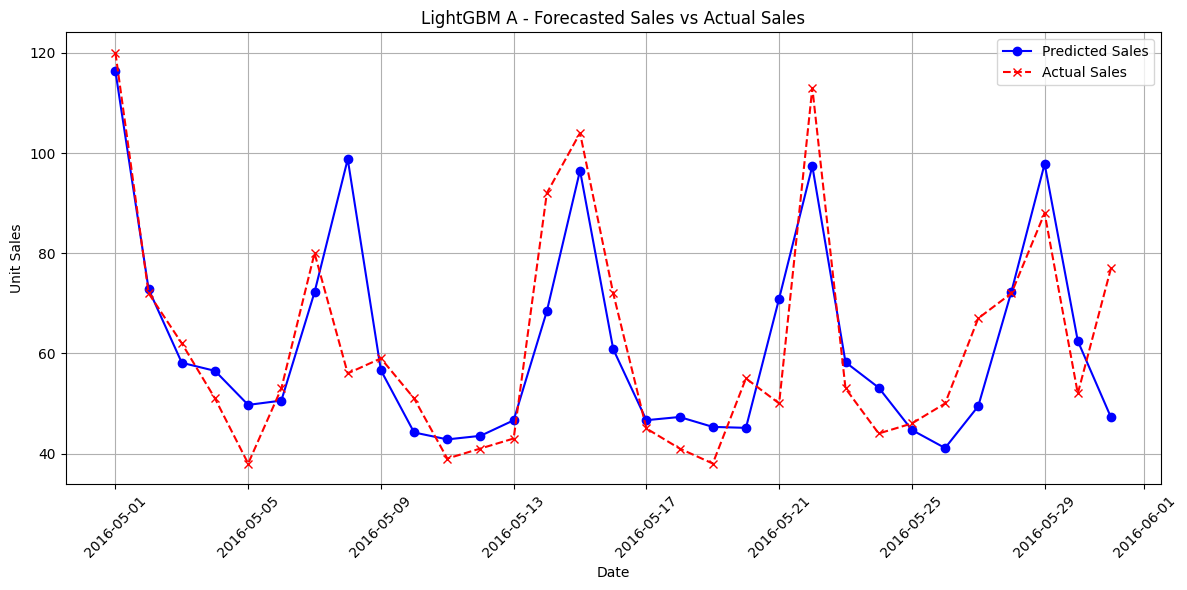

In [ ]:
# Model LightGBM A

model_name_A = 'LightGBM A'
plot_forecast_vs_actual(predictions_A, actual_data_A, model_name_A)

<Figure size 1000x600 with 0 Axes>

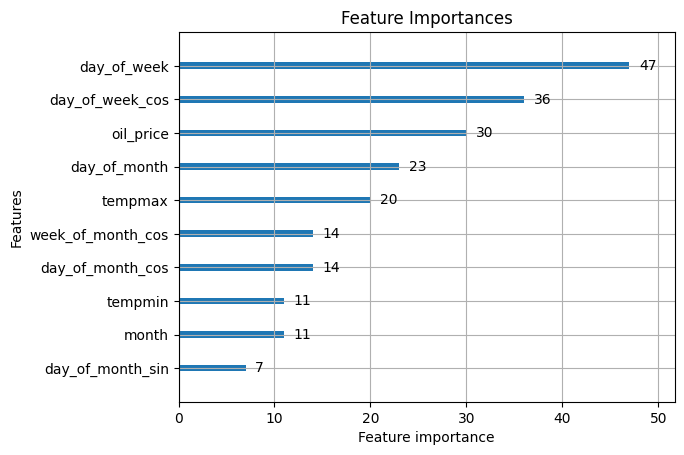

In [ ]:
#Model LightGBM A

# Plot feature importances
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_lgb_model_A, max_num_features=10)
plt.title("Feature Importances")
plt.show()

## Result Model LightGBM B

Forecast the value for the evaluation period

In [ ]:
# Model LightGBM B

# Define the testing period
test_start_date_B = '2016-05-01'
test_end_date_B = '2016-05-31'

# Run the forecast
predictions_B, training_dates_B = forecast_sales_B(dataset_lgbm_B, test_start_date_B, test_end_date_B)
print("Forecasting completed.")

# Ensure predictions are being calculated for each expected day
expected_days_B = pd.date_range(start=test_start_date_B, end=test_end_date_B)
missing_days_B = [day.strftime('%Y-%m-%d') for day in expected_days_B if day.strftime('%Y-%m-%d') not in predictions_B]
if missing_days_B:
    print("Warning: No predictions for days:", missing_days_B)
else:
    print("All days have predictions.")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

Evaluate the results

In [ ]:
#Model LightGBM B

# Extract actual sales data for the test period
actual_data_B = dataset_lgbm_B[test_start_date_B:test_end_date_B]

# Check actual data extraction
print("Checking actual data extraction...")
if actual_data_B.empty:
    print("Error: Actual data extraction returned an empty DataFrame.")
else:
    print(f"Actual data extracted for {len(actual_data_B)} days.")

results_B = evaluate_forecast(predictions_B, actual_data_B)
print(results_B)

Checking actual data extraction...
Actual data extracted for 31 days.
              Metric      Value
0       Overall RMSE  14.560659
1             RMSE %  19.183188
2  Variance of RMSEs  87.561361
3        Overall MAE  11.155780
4              MAE %  14.697372
5       Overall MAPE  15.577710
6               Bias  -1.855454
7             Bias %  -2.444499


Predicted value for each day

In [ ]:
#Model LightGBM B

print("Sample predictions:")
for date in list(predictions_B.keys())[:]:
    print(f"{date}: {predictions_B[date]}")

Sample predictions:
2016-05-01: 81.83753851883264
2016-05-02: 71.42658493401198
2016-05-03: 65.57708249103108
2016-05-04: 61.6184284974893
2016-05-05: 61.86997816169931
2016-05-06: 68.60198107282199
2016-05-07: 84.81012066032795
2016-05-08: 85.14684719607047
2016-05-09: 75.96408855512068
2016-05-10: 73.13810952176536
2016-05-11: 73.58782191894868
2016-05-12: 68.0163561648154
2016-05-13: 63.71846677419809
2016-05-14: 80.20469621219857
2016-05-15: 75.93729493867326
2016-05-16: 72.15760036779663
2016-05-17: 72.10836238364723
2016-05-18: 68.61161838258477
2016-05-19: 66.47857038757178
2016-05-20: 68.05853971509359
2016-05-21: 77.85977726749817
2016-05-22: 80.24449515519856
2016-05-23: 73.99112137043326
2016-05-24: 79.33529162601647
2016-05-25: 73.89680593773764
2016-05-26: 67.10719483600323
2016-05-27: 67.28925746244428
2016-05-28: 74.52239227827252
2016-05-29: 94.86883320533796
2016-05-30: 86.31765303064014
2016-05-31: 81.178032163484


Visualization of the results

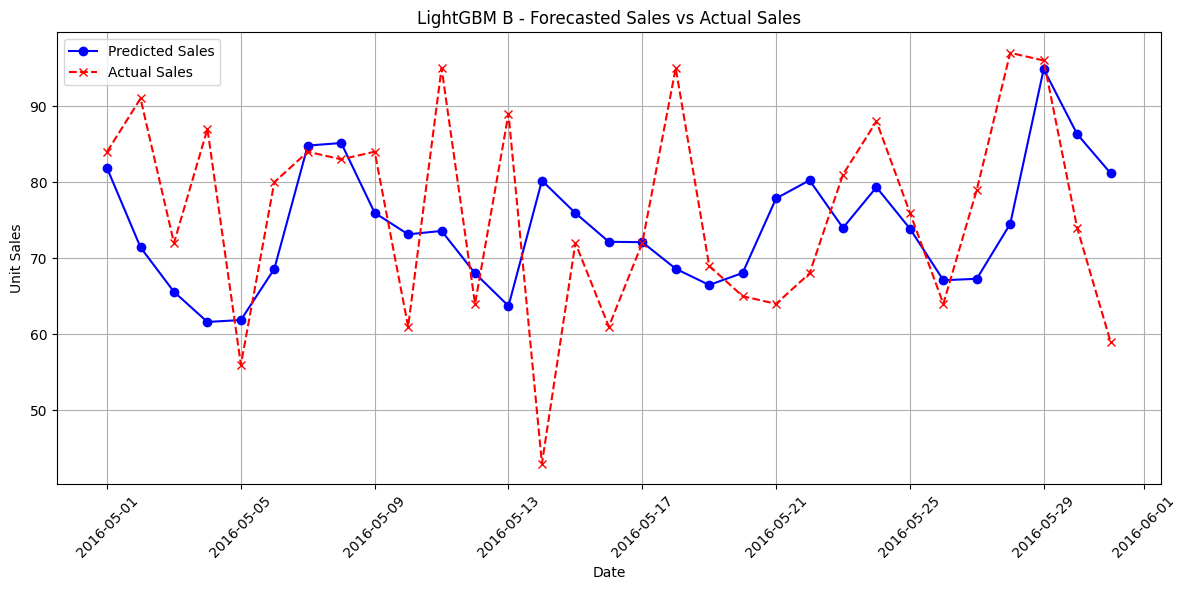

In [ ]:
# Model LightGBM B

model_name_B = 'LightGBM B'
plot_forecast_vs_actual(predictions_B, actual_data_B, model_name_B)

<Figure size 1000x600 with 0 Axes>

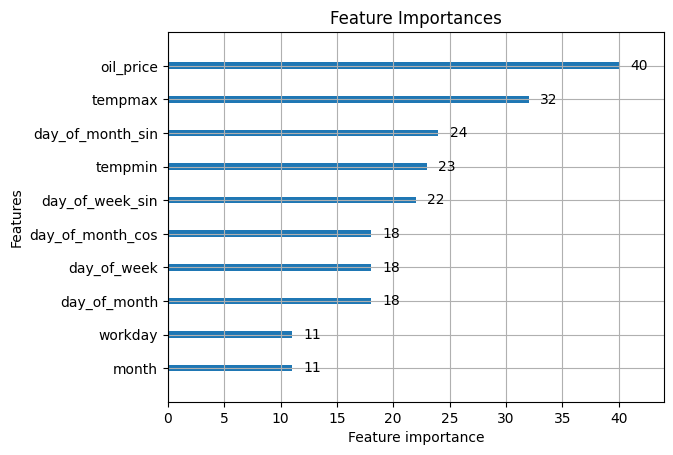

In [ ]:
#Model LightGBM B

# Plot feature importances
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_lgb_model_B, max_num_features=10)
plt.title("Feature Importances")
plt.show()

## Bonus Visualization

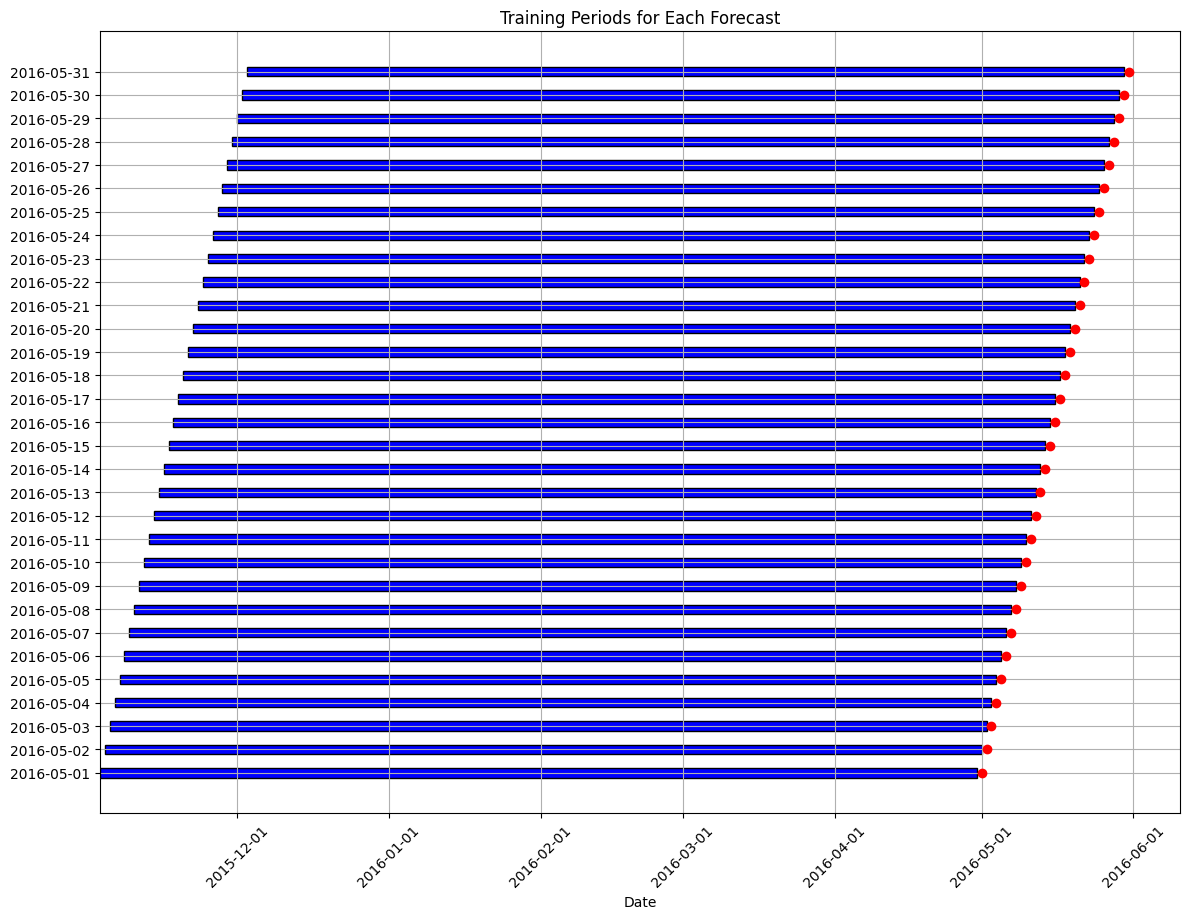

In [ ]:
def visualize_training_periods(training_dates):

    # Prepare figure and axes
    fig, ax = plt.subplots(figsize=(12, len(training_dates) * 0.3))  # Adjust size as needed

    # Generate bars for each training period
    for i, dates in enumerate(training_dates):
        start_date = dates['start']
        end_date = dates['end']
        forecast_date = end_date + pd.Timedelta(days=1)

        # Draw the training period bar
        ax.barh(i, (end_date - start_date).days, left=start_date, color='blue', edgecolor='black', height=0.4)

        # Draw a point for the forecasted day
        ax.plot(forecast_date, i, 'ro')

    # Set labels and titles
    ax.set_yticks(range(len(training_dates)))
    ax.set_yticklabels([dates['date'] for dates in training_dates])
    ax.set_xlabel('Date')
    ax.set_title('Training Periods for Each Forecast')

    # Improve date display
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function
visualize_training_periods(training_dates_A)